In [1]:
import math
import numpy as np
import pandas as pd

In [2]:
from scipy.spatial.distance import cosine

In [3]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [204]:
from matplotlib import font_manager, rc
import sys

if sys.platform in ["win32", "win64"]:
    font_name = "malgun gothic"
elif sys.platform == "darwin":
    font_name = "AppleGothic"

rc('font',family=font_name)

# 1. 데이터 전처리

In [4]:
glowpick = pd.read_csv('glowpick.csv')

In [5]:
glowpick.head()

,prod_name,brand_name,price,user_id,age,skin_type,gender,image_url,category,score
0,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",두피왕고민,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4
1,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",Ssseul0613,23,건성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
2,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",따꾸리이,24,중성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
3,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",총총이들,35,복합성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
4,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",수부지매트매트,24,복합성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4


### 사용자 관련 feature만 남기기

In [6]:
glow_df = glowpick[['user_id','age','skin_type','gender']]

In [7]:
glow_df.head()

,user_id,age,skin_type,gender
0,두피왕고민,30,민감성,f
1,Ssseul0613,23,건성,f
2,따꾸리이,24,중성,f
3,총총이들,35,복합성,f
4,수부지매트매트,24,복합성,f


### skin_type, gender -> one_hot encoding

In [8]:
skin_df = pd.get_dummies(glow_df['skin_type'], prefix = 'skin_type')
gender_df = pd.get_dummies(glow_df['gender'],prefix='gender')

In [9]:
glow_df = pd.concat([glow_df,skin_df,gender_df],axis=1)
glow_df.head()

,user_id,age,skin_type,gender,skin_type_건성,skin_type_민감성,skin_type_복합성,skin_type_중성,skin_type_지성,gender_f,gender_m
0,두피왕고민,30,민감성,f,0,1,0,0,0,1,0
1,Ssseul0613,23,건성,f,1,0,0,0,0,1,0
2,따꾸리이,24,중성,f,0,0,0,1,0,1,0
3,총총이들,35,복합성,f,0,0,1,0,0,1,0
4,수부지매트매트,24,복합성,f,0,0,1,0,0,1,0


In [10]:
glow_df

,user_id,age,skin_type,gender,skin_type_건성,skin_type_민감성,skin_type_복합성,skin_type_중성,skin_type_지성,gender_f,gender_m
0,두피왕고민,30,민감성,f,0,1,0,0,0,1,0
1,Ssseul0613,23,건성,f,1,0,0,0,0,1,0
2,따꾸리이,24,중성,f,0,0,0,1,0,1,0
3,총총이들,35,복합성,f,0,0,1,0,0,1,0
4,수부지매트매트,24,복합성,f,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
14215,랑그랑,30,복합성,f,0,0,1,0,0,1,0
14216,혜인쯔,28,건성,f,1,0,0,0,0,1,0
14217,훌라울라울랄라,30,건성,f,1,0,0,0,0,1,0
14218,박,27,민감성,f,0,1,0,0,0,1,0


In [11]:
glow_df.drop(['skin_type','gender'],axis=1,inplace=True)

In [12]:
glow_df.head()

,user_id,age,skin_type_건성,skin_type_민감성,skin_type_복합성,skin_type_중성,skin_type_지성,gender_f,gender_m
0,두피왕고민,30,0,1,0,0,0,1,0
1,Ssseul0613,23,1,0,0,0,0,1,0
2,따꾸리이,24,0,0,0,1,0,1,0
3,총총이들,35,0,0,1,0,0,1,0
4,수부지매트매트,24,0,0,1,0,0,1,0


### -중복 행 제거

In [13]:
glow_df = glow_df.drop_duplicates()

In [14]:
glow_df.reset_index(inplace=True, drop=True)
glow_df

,user_id,age,skin_type_건성,skin_type_민감성,skin_type_복합성,skin_type_중성,skin_type_지성,gender_f,gender_m
0,두피왕고민,30,0,1,0,0,0,1,0
1,Ssseul0613,23,1,0,0,0,0,1,0
2,따꾸리이,24,0,0,0,1,0,1,0
3,총총이들,35,0,0,1,0,0,1,0
4,수부지매트매트,24,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
9264,통큰팝콘,23,1,0,0,0,0,1,0
9265,리쁜이,30,0,1,0,0,0,1,0
9266,뀨유꾸유뀨뀨,24,1,0,0,0,0,1,0
9267,박,27,0,1,0,0,0,1,0


In [15]:
glow_matrix = glow_df.copy()

In [16]:
del glow_matrix['user_id']

### - 데이터 표준화 

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(glow_matrix)
glow_matrix.loc[:,:] = scaled_values

In [18]:
glow_matrix.head()

,age,skin_type_건성,skin_type_민감성,skin_type_복합성,skin_type_중성,skin_type_지성,gender_f,gender_m
0,0.271186,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.152542,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.169492,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.355932,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.169492,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [19]:
glow_matrix = glow_matrix.to_numpy()
glow_matrix

array([[0.27118644, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.15254237, 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.16949153, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.16949153, 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.22033898, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.15254237, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ]])

# 2.사용자 속성을 기반으로  코사인유사도 구하기

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
# 새로운 데이터 입력
new_data=[0.27118644, 0, 1, 0, 0,0,1, 0]

In [22]:
new_data = np.array(new_data).reshape(-1,1)

In [23]:
new_data.shape

(8, 1)

In [101]:
cos_sim = cosine_similarity(glow_matrix, new_data.reshape(1,-1))
cos_sim

array([[1.        ],
       [0.50841778],
       [0.50997441],
       ...,
       [0.50997441],
       [0.99939115],
       [0.9966391 ]])

In [102]:
similar_user_idx = np.argsort(cos_sim.transpose()[0])[::-1][:10]
similar_user_idx = similar_user_idx.tolist()
similar_user_idx

[0, 3142, 6407, 4400, 6384, 6350, 6140, 3049, 3011, 9095]

In [103]:
similar_user_id_df = glow_df.iloc[similar_user_idx,]
similar_user_id_list = similar_user_id_df[['user_id']] 
similar_user_id_list= similar_user_id_list.values.reshape(1,-1).tolist()[0]

In [104]:
similar_user_id_list

['두피왕고민',
 '다솜ck',
 '92',
 'modestJ',
 '에릭남',
 '메르치',
 '아르노',
 '윌리엄너는진챠귀여워',
 '도토딘',
 '슘쌤']

# 3. 사용자 기반 협업필터링

In [105]:
user_prod = glowpick.pivot_table('score', index='user_id', columns='prod_name')
user_prod.fillna(0, inplace=True)
user_prod

prod_name,1025 독도 로션,1899 싱글에센스,2세대 시카페어 토너,PRA 비피다 나이트 앰플,결광 가득 에센스 토너 [3번],굳세라 수퍼 세라마이드 에멀젼,굳세라 수퍼 세라마이드 크림 인 세럼,그린더마 마일드 시카세럼,그린티 씨드 세럼,그린티 씨드 에센스 인 로션,...,하이드라 앰플 토너,하이드라비오 에센스 로션,하이드로 인텐시브 모이스쳐라이징 에멀젼,하이드로 피에이치 밸런스 젤,하이포알러제닉 모이스처라이징 크림 보습패드,하이포알러제닉 시카 레스큐 거즈 패드,허니 로얄락틴 프로폴리스 앰플,히아루로닉 에센셜 토너,히아루론산 앰플 스킨,히알론 액티브 10 블루 캡슐 세럼
user_id,,,,,,,,,,,,,,,,,,,,,
#tomato100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#달덩이,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#효블리,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&stories,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'-'v,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
힘쒜,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
힘을내시요,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
힘흔홍,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
# 유저와 유저 간의 유사도
user_based_collab = cosine_similarity(user_prod, user_prod)
user_based_collab = pd.DataFrame(user_based_collab, index=user_prod.index, columns=user_prod.index)
user_based_collab

user_id,#tomato100,#달덩이,#효블리,&stories,'-'v,'^'수인'^','유징징',*ㅇㅅㅇ*,*스가와라코우시*,+조이+,...,힌듕아,힌유즈,힐링버드,힘내,힘드렀돠,힘쒜,힘을내시요,힘흔홍,힛헷홋,힣히ㅣㅎ
user_id,,,,,,,,,,,,,,,,,,,,,
#tomato100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.780869,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
#달덩이,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
#효블리,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
&stories,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
'-'v,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
힘쒜,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
힘을내시요,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.816497,0.0,0.0,1.0,0.0,0.0,0.0
힘흔홍,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0


In [107]:
# 코사인 유사도 가장 높은 유저 15명이 평가한 제품

In [110]:
import re

In [114]:
idx_list_1 = []

In [115]:
for u_id in similar_user_id_list:
    idx = re.search('[\d ,]+',str(glowpick[glowpick['user_id']==u_id].index).split('[')[1]).group()
    idx_list_1.extend(idx.split(', '))


In [140]:
idx_list_1 = list(map(int, idx_list))
print(idx_list_1)

[0, 3779, 8487, 9402, 5551, 8897, 8449, 8397, 8090, 3652, 4626, 13174, 3596, 4994, 13866]


In [142]:
user1_df = glowpick.iloc[idx_list_1,]
user1_df.head()

,prod_name,brand_name,price,user_id,age,skin_type,gender,image_url,category,score
0,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",두피왕고민,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4
3779,오가니언스 워터,프리메라 (primera),"30,000",다솜ck,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
8487,클래리파잉 모이스처라이저,닥터벨머 (Dr.Belmeur),"20,000",92,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,로션,4
9402,핌프로브 모이스처라이저,제로이드 (ZEROID),"30,000",92,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,로션,5
5551,수딩로션,제로이드 (ZEROID),"30,000",modestJ,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,로션,3


In [ ]:
# 코사인 유사도 높은 유저와 비슷한 유저 30명이 평가한 제품

In [150]:
user_collab_id = []

In [161]:
for u_id in similar_user_id_list:
    user_collab_id.extend(user_based_collab[u_id].sort_values(ascending=False)[:11].index.tolist())

In [162]:
idx_list_2 =[]

In [163]:
for u_id in user_collab_id:
    idx = re.search('[\d ,]+',str(glowpick[glowpick['user_id']==u_id].index).split('[')[1]).group()
    idx_list_2.extend(idx.split(', '))

In [164]:
idx_list_2 = list(map(int, idx_list_2))

In [165]:
user2_df = glowpick.iloc[idx_list_2,]
user2_df.head()

,prod_name,brand_name,price,user_id,age,skin_type,gender,image_url,category,score
6,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",수망이,22,건성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
83,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",나지현,28,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4
19,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",사도더사,22,지성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
79,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",댕댕6,28,건성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4
76,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",maxiemoo,27,복합성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5


In [170]:
user2_df.head(15)

,prod_name,brand_name,price,user_id,age,skin_type,gender,image_url,category,score
6,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",수망이,22,건성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
83,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",나지현,28,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4
19,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",사도더사,22,지성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
79,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",댕댕6,28,건성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4
76,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",maxiemoo,27,복합성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
89,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",꽃망두,25,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
23,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",곰곰도리,33,지성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4
58,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",HDDDDDD,27,복합성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4
51,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",겨우리잉,26,복합성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4
28,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",gpalsdld,26,복합성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4


In [171]:
user1_df.head()

,prod_name,brand_name,price,user_id,age,skin_type,gender,image_url,category,score
0,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",두피왕고민,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4
3779,오가니언스 워터,프리메라 (primera),"30,000",다솜ck,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
8487,클래리파잉 모이스처라이저,닥터벨머 (Dr.Belmeur),"20,000",92,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,로션,4
9402,핌프로브 모이스처라이저,제로이드 (ZEROID),"30,000",92,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,로션,5
5551,수딩로션,제로이드 (ZEROID),"30,000",modestJ,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,로션,3


In [172]:
collab_filter = pd.concat([user1_df,user2_df])

In [179]:
collab_filter.reset_index(inplace=True,drop=True)
collab_filter.head()

,prod_name,brand_name,price,user_id,age,skin_type,gender,image_url,category,score
0,캐롯 카로틴 카밍 워터 패드,스킨푸드 (SKINFOOD),"26,000",두피왕고민,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,4
1,오가니언스 워터,프리메라 (primera),"30,000",다솜ck,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,스킨/토너,5
2,클래리파잉 모이스처라이저,닥터벨머 (Dr.Belmeur),"20,000",92,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,로션,4
3,핌프로브 모이스처라이저,제로이드 (ZEROID),"30,000",92,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,로션,5
4,수딩로션,제로이드 (ZEROID),"30,000",modestJ,30,민감성,f,https://dn5hzapyfrpio.cloudfront.net/home/glow...,로션,3


In [180]:
collab_filter = collab_filter.drop_duplicates()
collab_filter.shape

(176, 10)

In [199]:
# 제품별 score count
collab_filter.pivot_table('user_id',index='prod_name', columns='score',aggfunc='count').fillna(0)

score,1,2,3,4,5
prod_name,,,,,
레드 프로 레티놀 세럼,0.0,0.0,0.0,1.0,0.0
레스온스킨 에멀젼,0.0,0.0,1.0,8.0,7.0
마데카 솔루션 에센스 플러스,0.0,0.0,1.0,8.0,7.0
모닝 부스트 하이드레이팅 로션,0.0,0.0,2.0,4.0,2.0
블랙티 유스 인핸싱 앰플,0.0,0.0,0.0,0.0,1.0
센텔카밍샷 앰플,0.0,0.0,0.0,1.0,0.0
수딩로션,0.0,0.0,2.0,3.0,4.0
아르간 20˚ 스팀 에멀젼,0.0,0.0,4.0,8.0,5.0
어드밴스드 나이트 리페어 인텐스 리셋 컨센트레이트,0.0,1.0,2.0,1.0,4.0


In [ ]:
sns.heatmap(tip2, cmap='Blues', annot=True) 
plt.show()

In [206]:
count_df = collab_filter.pivot_table('user_id',index='prod_name', columns='score',aggfunc='count').fillna(0)

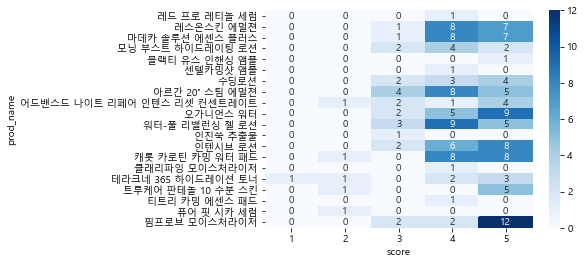

In [207]:
sns.heatmap(count_df, cmap='Blues', annot=True) 
plt.show()

In [210]:
# 제품별 score count
mean_df = collab_filter.pivot_table('score',index='brand_name',aggfunc='mean').fillna(0)


,score
brand_name,
네이처리퍼블릭 (NATURE REPUBLIC),4.058824
닥터벨머 (Dr.Belmeur),4.000000
메디힐 (MEDIHEAL),4.000000
센텔리안24 (CENTELLIAN24),4.375000
숨37˚ (sum37˚),4.117647
스킨푸드 (SKINFOOD),4.352941
앰플엔 (AMPLEN),4.000000
에스트라 (AESTURA),3.714286
에스티 로더 (ESTEE LAUDER),4.000000


In [194]:
top5 =collab_filter.groupby('prod_name')[['score']].mean().sort_values(ascending=False,by='score')

,score
prod_name,
블랙티 유스 인핸싱 앰플,5.0000
핌프로브 모이스처라이저,4.6250
트루케어 판테놀 10 수분 스킨,4.5000
오가니언스 워터,4.4375
마데카 솔루션 에센스 플러스,4.3750
